In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
%matplotlib inline
from sklearn import metrics

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [3]:
df = pd.read_csv('final.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

# Drop null values
df.dropna(inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0
2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0
2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0
2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0
2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0
...,...,...,...,...,...,...,...,...
2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888.0
2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962.0
2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895.0


In [4]:
df = df[["Adj Close", "ts_polarity", "twitter_volume"]]
df.head()

,Adj Close,ts_polarity,twitter_volume
Date,,,
2016-01-04,24.44,0.070389,1133.0
2016-01-05,23.83,0.133635,1430.0
2016-01-06,23.36,0.072042,1949.0
2016-01-07,22.38,0.074369,2289.0
2016-01-08,22.50,0.051595,2235.0


In [5]:
# pct change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

# Drop null values
df.dropna(inplace = True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,
2016-01-05,23.83,0.133635,1430.0,-0.024959
2016-01-06,23.36,0.072042,1949.0,-0.019723
2016-01-07,22.38,0.074369,2289.0,-0.041952
2016-01-08,22.50,0.051595,2235.0,0.005362
2016-01-11,22.86,0.019443,1222.0,0.016000
...,...,...,...,...
2019-08-26,51.12,0.072340,888.0,0.019139
2019-08-27,50.54,0.117541,962.0,-0.011346
2019-08-28,50.88,0.061477,895.0,0.006727


In [6]:
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_polarity, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1)

In [7]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 4

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [8]:
# Use 70% of the data for training and 30% for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

# Set X_train, X_test, y_train, t_test
X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [11]:
# Create the XG Boost regressor instance
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [12]:
model.fit(X_train, y_train.ravel())

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

In [13]:
predicted = model.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
rmse= np.sqrt(metrics.mean_squared_error(y_test, predicted))

In [16]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.05063463935200767
R-squared : 0.9538979685966077


In [17]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [18]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head

<bound method NDFrame.head of              Real  Predicted
Date                        
2018-07-27  46.39  47.355892
2018-07-30  46.13  46.198818
2018-07-31  46.22  46.420559
2018-08-01  48.95  46.264809
2018-08-02  50.38  48.828800
...           ...        ...
2019-08-26  51.12  50.421589
2019-08-27  50.54  51.151466
2019-08-28  50.88  50.846745
2019-08-29  51.74  51.139729
2019-08-30  51.67  51.867397

[276 rows x 2 columns]>

In [19]:
stocks

,Real,Predicted
Date,,
2018-07-27,46.39,47.355892
2018-07-30,46.13,46.198818
2018-07-31,46.22,46.420559
2018-08-01,48.95,46.264809
2018-08-02,50.38,48.828800
...,...,...
2019-08-26,51.12,50.421589
2019-08-27,50.54,51.151466
2019-08-28,50.88,50.846745


In [20]:
import matplotlib.pyplot as plt

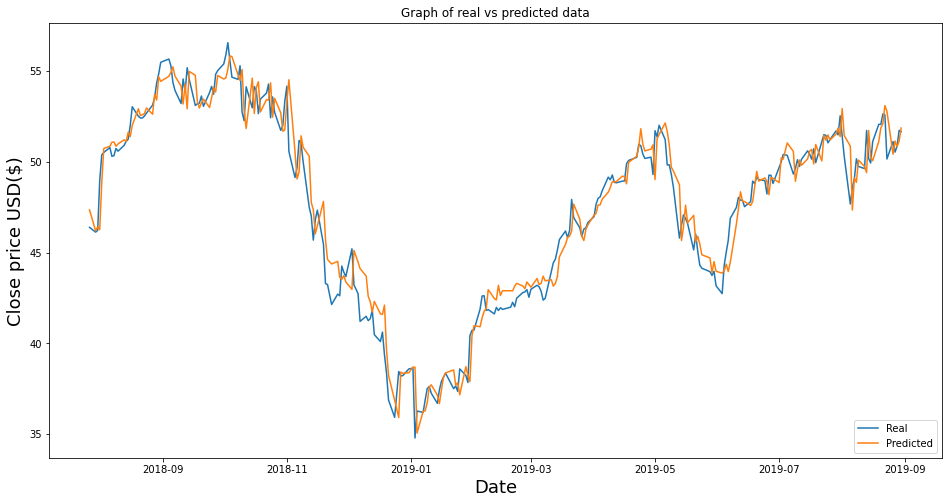

In [22]:
plt.figure(figsize=(16,8))
plt.title('Graph of real vs predicted data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD($)', fontsize=18)
plt.plot(stocks['Real'])
plt.plot(stocks[ 'Predicted'])
plt.legend(['Real', 'Predicted'], loc= 'lower right')
plt.show()

This XGBoost Regressor model:RMSE: 0.0477 | R-squared: 95.92%

